# Kolmogorov Smirnov Two Sample Test

We run a two-sided KS test to see if two datasets (i.e. two methods of generating stochastic rainfall) were drawn from the sample underlying distribution. We use a parametric and non-parametric approach to estimate rainfall:
- Parametric: generate rainfall frome exponential distribution
- Non-parametric: use empirical rainfall distribution to draw from a normal distribution (check)

We use a KS test because it is non-parametric and distribution agnostic, and can be used to compare two samples of data. Our hypotheses are:
- `H_0` (null hypothesis): Two samples (datasets) come from the same distribution.
- `H_1` (altnerative hypothesis): Two samples are from different distributions. 

And then use the Test statistic, `D`, or level of significance, `alpha`, to determine the result. 

## Table of Contents
Notebook is divided into three parts:
1. Part 1: [Generate non-parametric rainfall](#part1)
2. Part 2: [Import exponential rainfall data](#part2)
3. Part 3: [Run KS Two Sample Test](#part3)

In [32]:
# import packages, objects, set module path
from math import exp
import numpy as np
import pandas as pd
from numpy.random import exponential, uniform
from dateutil.relativedelta import *
import scipy.stats as st
from datetime import timedelta, datetime
import os
import sys
import glob
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from farm import Climate
from farm.climate import make_climate_parameters

## Get non-parametric estimation of rainfall  <a class="anchor" id="part1"></a>

Use code from `make_climate_parameters` function to import rainfall.

In [34]:
station='OL JOGI FARM'
data_file="../data/CETRAD/CETRAD_rainfall.csv"
year_min=30
interval='dekad'

# Prepare the CETRAD dataset.
df = pd.read_csv(data_file)  # Read in the raw csv data.

# Step 1. Convert text strings into datetime objects.
format = '%m/%d/%y' # Column RDate has data in M/D/YY
df['Datetime']=pd.to_datetime(df['RDate'], format=format) # Create a new column of datetime objects using RDate.

# 2. Step 2. Convert future dates inferred during the conversion back into 20th century dates.
# Python is a future-looking programming language, and assumes that 1/1/34 is Jan 1, 2034.
# We can fix this by finding all the dates in the future (dt > datetime.now()) and removing 100 years from
# their value. This requires using the relativedelta function, which handles weird stuff like leap years.
df['Datetime'] = df['Datetime'].map(lambda dt: dt+relativedelta(years=-100) if dt > datetime.now() else dt)

# Step 3. Extract the Year and Month from the Datetime to make aggregation easier.
df['Year'] = [dt.year for dt in df['Datetime']]
df['Month'] = [dt.month for dt in df['Datetime']]
df['Week'] = [dt.week for dt in df['Datetime']]
df['Dekad'] = df['Datetime'].dt.dayofyear//10+1

n_years = len(df['Year'].unique())

# Step 4. Use the Datetime values as the index for this dataframe.
df = df.set_index(pd.DatetimeIndex(df['Datetime']))  # Set the Datetime column as the dataframe index

# Step 5.  Delete the old RDate column, which we no longer need. 
# We will keep the Datetime column, in case we need it later.
df = df.drop(['RDate'], axis=1)

columns = [station] + ['Year', 'Month', 'Week', 'Dekad', 'Datetime']
rainfall = df[columns]

# First, find all the rows in the data where it rained and group by month.
rain_days = rainfall.loc[rainfall[station] > 0]

# Find all locations in the data where an observation was made.
all_days = rainfall.loc[rainfall[station] >= 0] 

# Find just the rainfall amounts on days that it rained.
data = rainfall.loc[rainfall[station] > 0][station]

# Fit the daily rainfall amounts to an exponential distribution.
#check_exponential(data)

if interval == 'month':
    # Determine the Monthly values of alpha and lambda from the station data:
    lambda_values = (
        rain_days.groupby('Month')[station].count() /
        all_days.groupby('Month')[station].count()
    )
    alpha_values = rain_days.groupby('Month')[station].mean()
elif interval == 'dekad':
    lambda_values = (
        rain_days.groupby('Dekad')[station].count() / 
        all_days.groupby('Dekad')[station].count()
    )
    alpha_values = rain_days.groupby('Dekad')[station].mean()
else:
    raise(NotImplementedError)

### Test code for generating rainfall using non-parametric approach

In [35]:
# Step 1: Sort X {x_0....x_n} from small to large
rain_days = rainfall.loc[rainfall['OL JOGI FARM'] > 0]
x = pd.DataFrame(rain_days['OL JOGI FARM']).sort_values(by='OL JOGI FARM').values.tolist()
x = pd.DataFrame(x); print('number of rainfall events, len(x):',len(x))

number of rainfall events, len(x): 1858


In [36]:
# Step 2: Draw random number, u, from uniform distribution {0,1}
u = np.random.uniform(low=0.0, high=1.0, size=None); print('random number, u:',u)

random number, u: 0.20600474550244285


In [37]:
# Step 3: Get sample: X [u*len(x)] and round to an integer
ix = int(u*len(x)); print('index for sample, ix:',ix)

index for sample, ix: 382


In [38]:
# Step 4: Locate that rainfall sample by index
x.iloc[ix,0] # row ix, column 0

2.5

In [ ]:
# Step 5: Generate 365 integer numbers 
data = []

for i in np.arange(1,366):
    u = np.random.uniform(low=0.0, high=1.0, size=None)
    ix = int(u*len(x))
    x.iloc[ix,0] 
    data.append(ix)

# Step 6: Get rainfall for those integer numbers
rf = x.iloc[data]

# Step 7: Don't want it to rain all of the time
t_sim=365

# Force doy to be in [1,365]:
doy_start=1
doys = np.arange(doy_start, doy_start + t_sim)
while (doys - 365 > 0).any() == True:
        doys = doys - 365 * ((doys - 365) > 0)
#amounts = [exponential(scale=s0_climate.alpha_r[doy-1], size=1)[0] for doy in doys]
amounts= rf[0].to_list()

s0_climate = Climate(data_file=data_file, station=station, interval=interval)

Check this part with Kelly: Okay to use the same lambdas as before, but changing alphas

In [48]:
rain_days = [(uniform(low=0, high=1, size=1) <= s0_climate.lambda_r[doy-1] ).astype(int) for doy in doys]
final = np.multiply(amounts, [v[0] for v in rain_days])
len(final)
final.sum()

535.9

### Generate rainfall for 10,000 seasons

In [9]:
final_rf = []

for z in np.arange(0,10000):

    # Step 1: Sort X {x_0....x_n} from small to large
    rain_days = rainfall.loc[rainfall['OL JOGI FARM'] > 0]
    x = pd.DataFrame(rain_days['OL JOGI FARM']).sort_values(by='OL JOGI FARM').values.tolist()
    x = pd.DataFrame(x); #print('number of rainfall events, len(x):',len(x))

    # Step 2: Draw random number, u, from uniform distribution {0,1}
    u = np.random.uniform(low=0.0, high=1.0, size=None); #print('random number, u:',u)

    # Step 3: Get sample: X [u*len(x)] and round to an integer
    ix = int(u*len(x)); #print('index for sample, ix:',ix)

    # Step 4: Locate that rainfall sample by index
    x.iloc[ix,0] # row ix, column 0

    # Step 5: Generate 365 integer numbers 
    data = []

    for i in np.arange(1,366):
        u = np.random.uniform(low=0.0, high=1.0, size=None)
        ix = int(u*len(x))
        x.iloc[ix,0] 
        data.append(ix)

    # Step 6: Get rainfall for those integer numbers
    rf = x.iloc[data]

    # Step 7: Don't want it to rain all of the time
    t_sim=365

    doy_start=1
    while (doys - 365 > 0).any() == True:
            doys = doys - 365 * ((doys - 365) > 0)
    #amounts = [exponential(scale=s0_climate.alpha_r[doy-1], size=1)[0] for doy in doys]
    amounts= rf[0].to_list()

    rain_days = [(uniform(low=0, high=1, size=1) <= s0_climate.lambda_r[doy-1] ).astype(int) for doy in doys]
    final = np.multiply(amounts, [v[0] for v in rain_days])
    #len(final)
    #final.sum()
    final_rf.append(final)
    

In [49]:
# Let's check out rainfall from a random season
final_rf[101]

array([ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. , 14. ,  0. ,  0. ,  4. ,  0. ,  0. ,  0. , 12. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , 10. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  3. ,  0. ,  0. ,  0. , 17.5,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  2.5,  0. ,  0. ,  0. ,  0. ,  5.5,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , 16.5,  0. ,
        0. ,  0. ,  0. ,  0. , 13. ,  0. ,  6.3,  1. ,  0. ,  1. ,  1.8,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  4. , 14.2,  0. ,  0. ,
        0. , 29.4,  0. ,  8.1,  0. ,  0. ,  0. ,  4. ,  0. ,  0. ,  0. ,
        6. , 16. ,  7. , 10.1,  0. , 13. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  4

In [75]:
type(final_rf) # list of lists
output_np = pd.DataFrame.from_records(final_rf) # get all the data as a dataframe where the row is the simulation and the column is the day number

## Grab rainfall (exponential) from simulations <a class="anchor" id="part2"></a>

In [70]:
# Import in the data
n_sim = 10000
no_sims = np.arange(1,n_sim)

# reimport 
files = glob.glob('../output/final/*.csv')
output = []
for f, n in zip(files, no_sims):
    f_ = pd.read_csv(f).drop('Unnamed: 0',axis=1)
    output.append(f_)

#output[99]

The output is time series with all of the variables (kc, LAI, etc.. ). We want just the rainfall.

In [76]:
output_rf = [df['R'] for df in output]
output_p = pd.DataFrame.from_records(output_rf)

Datasets `output_np` and `output_p` are not the same format, so let's get those to talk to each other.

In [77]:
output_np = output_np.drop(0) # want this to be the same length as output_p
output_np = output_np.iloc[:, 60:240] # want only days 60 to 240

It takes too long to run the KS test with 10,000 seasons, so let's just grab the first 1000.

In [78]:
# want only first 1000 rows
output_np = output_np.iloc[0:1000:,]
output_p = output_p.iloc[0:1000:,]

Get the actual rainfall values.

In [79]:
op = pd.melt(output_p)['value'].tolist()
onp = pd.melt(output_np)['value'].tolist()

Now the two datasets are the same length:

In [81]:
print(len(op), len(onp))

180000 180000


## Do KS test  <a class="anchor" id="part3"></a>

For the KS two sample test, we assume two empirical distributions and then take the difference between the two. The beauty in this test lies the fact that we do not need to know or make any assumptions about the underlying distributions. 

Notes and code from here: [KS for Two Samples](https://towardsdatascience.com/when-to-use-the-kolmogorov-smirnov-test-dd0b2c8a8f61)

In order to compare the two datasets, we need to do the following:
1. Order each sample
2. Cat into one sorted array
3. Compute the observed CDFs of the two samples
4. Compute the maximum absolute different, `D_n`
5. Compare against `D_crit`

In [82]:
# Second method for doing this

# sort samples from non-parametric method (sample a)
samp_a = np.sort(onp); samp_a

# sort samples from original method, exponential (sample b)
samp_b = np.sort(op); samp_b

#concatenate and sort
samp_conc = np.sort(np.concatenate((onp, op)))
#print("samp_conc:\n{}".format(samp_conc))

#cdf of sample a
samp_a_cdf = [np.round(st.percentileofscore(samp_a, value)/100, 1) for value in samp_conc]
#print('samp_a_cdf:\n{}'.format(samp_a_cdf))
#print(20*'-')

#cdf of sample b
samp_b_cdf = [np.round(st.percentileofscore(samp_b, value)/100, 1) for value in samp_conc]
#print('samp_b_cdf:\n{}'.format(samp_b_cdf))
#print(20*'-')

#compute absolute difference
samp_diff = np.abs(np.subtract(samp_a_cdf, samp_b_cdf))
#print('samp_diff:\n{}'.format(samp_diff))

Run the statistics on it. Two-sided KS test: [ks_2samp method](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html#scipy.stats.ks_2samp) in scipy.

Additional info from: https://sites.google.com/a/ucsc.edu/krumholz/teaching-and-courses/ast119_w15/class-10

In [88]:
# first argument is the dataset, the second is the second dataset
st.ks_2samp(op, onp)

Ks_2sampResult(statistic=0.014522222222222214, pvalue=6.527375005960466e-17)

The `ks_2samp` method returns a tuple: first is D, maximum difference between the CDF of the input data and the model CDF. The second is the p-value, i.e. the probability that if the data was actually drawn from the proposed CDF, then the resulting value of D would have been as/larger than the one we measured

E.g., D = 0.0305, p-value 0.3, then 30% of the time we would expect a value of D as large as the one actually got even if the data had been drawn from the proposed distribution. There cannot reject the hypothesis that the data were drawn from the proposed distribution

**In this case**, we can reject the null hypothesis since the p-value is well below 1%. Therefore the two datasets come from different distributions. I.e., it is probable that the two distributions are different. 

There are two options for interpreting the result: 1. Use p-level as level of significant where p < 0.01 is highly significant or 2. Use statistic value given by python and compare it to the [KS-test critical value table](https://sparky.rice.edu//astr360/kstest.pdf) according to sample size. When statistic value is greater than the critical value, then the two distributions are different.

Text(0.5, 1.0, 'KS Goodness of Fit for two methods of simulating rainfall')

/opt/anaconda3/envs/maize-Toff/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


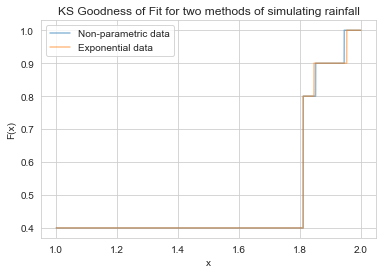

In [90]:
# Let's visualize this in a figure

x3 = np.linspace(1, 2, 360000)
plt.plot(x3, samp_a_cdf, label='Non-parametric data', alpha=0.5)
plt.plot(x3, samp_b_cdf, label='Exponential data', alpha=0.5)
plt.xlabel('x')
plt.ylabel('F(x)')

plt.legend()
plt.title('KS Goodness of Fit for two methods of simulating rainfall')